# Move existing user content to a new user
### The base of this notebook copied from [Esri's Sample Notebook](http://notebook.esri.com/user/ECTxITBLYSFPb4mu4nPa7mUCI/notebooks/samples/03_org_administrators/move_existing_user_content_to_a_new_user.ipynb#)

This sample illustrates how to "move" a portal user's account to a new user account.  This is accomplished by creating a new user account, assigning ownership/membership of this new user to all the applicable groups, and then reassigning the old user's content to the new user connect while maintaining folder structure under 'My Contents'.

For some customers, this is a useful utility when they have used one type of Identity store, e.g. Built-in Users, and then decided to switch to a different Identity provider, such as SAML or IWA.  In these situations, it is highly likely new userids will be created as new user accounts get created.  This Jupyter Notebook is an example of how to use the Python API to take a user's content and migrate it to a new userid while maintaining all group membership and content (including folders in My Content).

First enable intellisense:

In [2]:
%config IPCompleter.greedy=True

In [3]:
from arcgis.gis import *
from IPython.display import display

Create a connection to the portal.  If you only include a username, GIS will prompt you for your password.

In [4]:
gis = GIS("https://waketest.maps.arcgis.com", "lpiedrahita") 
print("Connected to {0}".format(gis.url))

Enter password: ········
Connected to https://waketest.maps.arcgis.com


Establish variables for the current userid that is being transitioned and for the new userid to be created (Although, in this case this username already exists).

In [5]:
orig_userid = "lpiedrahita"
new_userid = "benstrausstest"

# orig_userid, new_userid = new_userid, orig_userid

Validate that the original userid is valid and accessible.

<User username:lpiedrahita>
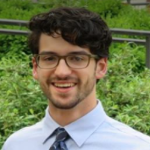

In [37]:
olduser = gis.users.get(orig_userid)
olduser

Create a new userid, making sure to use `provider='enterprise'` if Web Tier Authentication is going to be used.  If moving user accounts from one userid to another, make sure that a proper password is used that meets security requirements.

In [25]:
# newuser = gis.users.create(username = new_userid,
#                             password = "pwdNotUsed",
#                             firstname = olduser.firstName,
#                             lastname = olduser.lastName,
#                             email = olduser.email,
#                             description = olduser.description,
#                             role = olduser.role,
#                             provider = 'enterprise',
#                             idp_username=None)  
newuser = gis.users.get(new_userid)
newuser

<User username:lpiedrahita>

Once the new user has been successfully created, reassign group ownership and group membership from the old user to the new user.

In [20]:
olduser_groups = olduser['groups']
grp = gis.groups.get(olduser_groups[0]["id"])
grp.title
# group_reassigned = grp.reassign_to(orig_userid)
# group_reassigned

'WebAppTemplates'

In [27]:
for group in olduser_groups:
    grp = gis.groups.get(group['id'])
    if (grp.owner == orig_userid):
        grp.reassign_to(new_userid)
    else:
        grp.add_users(new_userid)
        grp.remove_users(orig_userid)

In [28]:
newuser_groups = newuser['groups']
newuser_groups
# newuser_groups[0]['id'] == olduser_groups[0]['id']

[{'id': '112c1730df8c4985b802d831ead876dc',
  'title': 'WebAppTemplates',
  'isInvitationOnly': True,
  'owner': 'lpiedrahita',
  'description': None,
  'snippet': None,
  'tags': ['Configurable Apps'],
  'phone': None,
  'sortField': 'title',
  'sortOrder': 'asc',
  'isViewOnly': False,
  'thumbnail': None,
  'created': 1566938531000,
  'modified': 1571258390000,
  'access': 'org',
  'capabilities': [],
  'isFav': False,
  'isReadOnly': False,
  'protected': False,
  'autoJoin': False,
  'notificationsEnabled': False,
  'provider': None,
  'providerGroupName': None,
  'leavingDisallowed': False,
  'hiddenMembers': False,
  'displaySettings': {'itemTypes': ''},
  'userMembership': {'username': 'lpiedrahita',
   'memberType': 'owner',
   'applications': 0}},
 {'id': '76f52e4b59e74c37a86244076dc9525a',
  'title': 'Featured Content',
  'isInvitationOnly': True,
  'owner': 'lpiedrahita',
  'description': None,
  'snippet': 'Group to put featured content that will show up on the home page.'

Once group ownership/membership has been successfully changed, reassign all the original user's content to the new user.  This happens in 2 passes.  First, reassign everything on the root folder of 'My Contents'.  Then, loop over each folder, create the same folder in the new user account, and reassign items in each folder to the new user in the correct folder.

In [29]:
olduser_content = olduser.items()
olduser_content

[<Item title:"tes" type:Dashboard owner:benstrausstest>,
 <Item title:"test" type:Web Mapping Application owner:benstrausstest>]

In [30]:
olduser_folders = olduser.folders
olduser_folders

[{'username': 'benstrausstest',
  'id': '13b0eb9d632843d2ad16a53853adae6b',
  'title': 'other stuff',
  'created': 1570742536000},
 {'username': 'benstrausstest',
  'id': '850e461e3c9b4157a20d738f757a25b9',
  'title': 'park stuff',
  'created': 1570742550000},
 {'username': 'benstrausstest',
  'id': '5247c1ffde2d4c988c744aa951cfbead',
  'title': 'solid waste stuff',
  'created': 1570742558000}]

In [31]:
def reassign_and_reshare(item, new_userid, target_folder=None):
    """
    Unshares the item, reassigns ownership to new_user (maintaining folder structure), 
    and reshares the item with groups it was previously shared with.
    
    This is necessary for items that are shared with a psecial group, such as one that allows editing,
    which blocks the item from being reassigned while shared.
    """
    if item.access == 'private':
        item.reassign_to(new_userid, target_folder=target_folder)
    else:
        shared_settings = [item.shared_with['everyone'], item.shared_with['org'], item.shared_with['groups']]
        item.unshare(shared_settings[2])
        item.reassign_to(new_userid, target_folder=target_folder)
        item.share(everyone=shared_settings[0], org=shared_settings[1], groups=shared_settings[2], allow_members_to_edit=True)        

In [32]:
print("Trying to move items in root folder...")
for item in olduser_content:
    # Move content in user's root folder
    try:
        reassign_and_reshare(item, new_userid)
        print("\tItem successfully moved: {0}".format(item))
    except Exception as e:
        print("\tAn error occured trying to reassign the item.\nItem: {0}\nError: {1}".format(item, e))

for folder in olduser_folders:
    print("Trying to move items in '{0}' folder...".format(folder['title']))
    # Move content in user's other folders
    gis.content.create_folder(folder['title'], new_userid)
    folderitems = olduser.items(folder=folder['title'])
    for item in folderitems:
        try:
            reassign_and_reshare(item, new_userid, target_folder=folder['title'])
            print("\tItem successfully moved: {0}".format(item))
        except Exception as e:
            print("\tAn error occured trying to reassign the item.\nItem: {0}\nError: {1}".format(item, e))
            break
    else:
        # If all items in a folder are reassigned successfully, delete that folder from the olduser's content
        print("\tItems successfully moved. Now Deleting folders...")
        folderEmpty = olduser.items(folder=folder['title']) == []
        if folderEmpty:
            # Delete Folder
            gis.content.delete_folder(folder=folder['title'], owner=orig_userid)
            print("\t{0}'s '{1}' folder deleted".format(orig_userid, folder['title']))
        else:
            print("\tFolder not empty.")

            

Trying to move items in root folder...
	Item successfully moved: <Item title:"tes" type:Dashboard owner:lpiedrahita>
	Item successfully moved: <Item title:"test" type:Web Mapping Application owner:lpiedrahita>
Trying to move items in 'other stuff' folder...
	Item successfully moved: <Item title:"Tracking Mosquitoes in Wake County" type:Web Map owner:lpiedrahita>
	Item successfully moved: <Item title:"Wake County EMS CIP 2018" type:Web Map owner:lpiedrahita>
	Item successfully moved: <Item title:"Wake County EMS  CIP 2018" type:Web Map owner:lpiedrahita>
	Item successfully moved: <Item title:"Tracking Mosquitoes in  Wake County" type:Web Map owner:lpiedrahita>
	Items successfully moved. Now Deleting folders...
	benstrausstest's 'other stuff' folder deleted
Trying to move items in 'park stuff' folder...
	Item successfully moved: <Item title:"Wake Park Locator" type:Web Map owner:lpiedrahita>
	Item successfully moved: <Item title:"Wake Park  Locator" type:Web Map owner:lpiedrahita>
	Items

In [33]:
newuser_content = newuser.items()
newuser_content

[<Item title:"tes" type:Dashboard owner:lpiedrahita>,
 <Item title:"test" type:Web Mapping Application owner:lpiedrahita>]

In [34]:
newuser_folders = newuser.folders
newuser_folders

[{'username': 'lpiedrahita',
  'id': '8c4d330ec6dd4bc39f3bb8762776a585',
  'title': 'other stuff',
  'created': 1571258432000},
 {'username': 'lpiedrahita',
  'id': '819678771d734dc78c96f5051a0d7022',
  'title': 'park stuff',
  'created': 1571258442000},
 {'username': 'lpiedrahita',
  'id': '4021317bed1e48589bc1164ac4a3bac9',
  'title': 'solid waste stuff',
  'created': 1571258447000}]